In [1]:
import numpy as np
import matplotlib.pyplot as plt

import keras

from sklearn.metrics import classification_report
from sklearn.manifold import TSNE

import medmnist
from medmnist import INFO

import sys
sys.path.insert(0,"../../")

import dataset_without_pytorch

from functions import split_data, get_label_counts, generate_testing_mixup_images, find_boundary_points
from plotting_functions import plot_3_confusion_matricies, plot_calibration, muba_curves
import pandas as pd


In [2]:
data_flag = 'octmnist'

download = True

image_size = 28

info = INFO[data_flag]

DataClass = getattr(dataset_without_pytorch, info['python_class'])

In [3]:
# load the data
train_dataset = DataClass(split='train', download=download, size = image_size)
test_dataset = DataClass(split='test', download=download, size = image_size)
val_dataset = DataClass(split='val', download=download, size = image_size)

Using downloaded and verified file: C:\Users\Will Poulett\.medmnist\octmnist.npz
Using downloaded and verified file: C:\Users\Will Poulett\.medmnist\octmnist.npz
Using downloaded and verified file: C:\Users\Will Poulett\.medmnist\octmnist.npz


In [4]:
RANDOM_SEED = 1

X_train, y_train, X_val, y_val, X_test_A, y_test_A, X_test_B, y_test_B = split_data(
  train_dataset, test_dataset, val_dataset, RANDOM_SEED = RANDOM_SEED, one_hot_encoded = True, num_classes=4, image_size = 28)


In [5]:
# As a sanity check to make sure we have the correct test data, check counts

get_label_counts(y_train,y_val,y_test_A,y_test_B,class_names = ['choroidal neovascularization', 'diabetic macular edema',  'drusen', 'normal'])


Train
{(0, 0, 0, 1): 46026, (0, 0, 1, 0): 7754, (0, 1, 0, 0): 10213, (1, 0, 0, 0): 33484}  ['choroidal neovascularization', 'diabetic macular edema', 'drusen', 'normal']

Val
{(0, 0, 0, 1): 5114, (0, 0, 1, 0): 862, (0, 1, 0, 0): 1135, (1, 0, 0, 0): 3721}  ['choroidal neovascularization', 'diabetic macular edema', 'drusen', 'normal']

Test A
{(0, 0, 0, 1): 69, (0, 0, 1, 0): 72, (0, 1, 0, 0): 80, (1, 0, 0, 0): 79}  ['choroidal neovascularization', 'diabetic macular edema', 'drusen', 'normal']

Test B
{(0, 0, 0, 1): 181, (0, 0, 1, 0): 178, (0, 1, 0, 0): 170, (1, 0, 0, 0): 171}  ['choroidal neovascularization', 'diabetic macular edema', 'drusen', 'normal']


In [6]:
test_set_A_df = pd.DataFrame({
    "image_index":[i for i in range(len(y_test_A))],
    "class":[np.argmax(label) for label in y_test_A]}) # 0 if normal, 1 if pneumonia

In [7]:
MUBA_ITERS = 20

muba_df = generate_testing_mixup_images(test_set_A_df, X_test_A, MUBA_ITERS, classes=4)

In [8]:
muba_df.head(-5)

,alpha_class_0,alpha_class_1,alpha_class_2,alpha_class_3,class_0_index,class_1_index,class_2_index,class_3_index,image,type,label
0,0.042613,0.957387,0.000000,0.000000,1.0,0.0,NaN,NaN,"[[[40.54527923988733], [33.84356921613381], [3...",mix,1
1,0.051810,0.948190,0.000000,0.000000,1.0,0.0,NaN,NaN,"[[[42.60551701344617], [35.96818942011636], [3...",mix,1
2,0.133143,0.866857,0.000000,0.000000,1.0,0.0,NaN,NaN,"[[[60.824055701981905], [54.75605744266883], [...",mix,1
3,0.172970,0.827030,0.000000,0.000000,1.0,0.0,NaN,NaN,"[[[69.74525125349055], [63.95604035516212], [6...",mix,1
4,0.206739,0.793261,0.000000,0.000000,1.0,0.0,NaN,NaN,"[[[77.30963131222339], [71.75680729073038], [6...",mix,1
...,...,...,...,...,...,...,...,...,...,...,...
674130,0.000000,0.000000,0.515770,0.484230,NaN,NaN,281.0,299.0,"[[[20.031540976270925], [21.51577048813546], [...",mix,2
674131,0.000000,0.000000,0.560538,0.439462,NaN,NaN,281.0,299.0,"[[[20.121076548505208], [21.560538274252604], ...",mix,2
674132,0.000000,0.000000,0.623545,0.376455,NaN,NaN,281.0,299.0,"[[[20.247089517340537], [21.62354475867027], [...",mix,2
674133,0.000000,0.000000,0.699221,0.300779,NaN,NaN,281.0,299.0,"[[[20.39844267936029], [21.699221339680147], [...",mix,2


In [9]:
model = keras.models.load_model("best_model_epoch_19.h5")
activations_model = keras.Model(model.input,model.layers[-2].output)

In [10]:
predictions_A = model.predict(X_test_A)
activations_A = activations_model.predict(X_test_A)

predictions_B = model.predict(X_test_B)
activations_B = activations_model.predict(X_test_B)

print("Stacking - this can take some time.")
stacked_images = np.stack(muba_df["image"])
predictions_mixup = model.predict(stacked_images)
activations_mixup = activations_model.predict(stacked_images)

22/22 [==============================] - 0s 7ms/step
Stacking - this can take some time.
21067/21067 [==============================] - 156s 7ms/step


In [11]:
muba_df["predictions_0"] = [p[0] for p in predictions_mixup]
muba_df["predictions_1"] = [p[1] for p in predictions_mixup]
muba_df["predictions_2"] = [p[2] for p in predictions_mixup]
muba_df["predictions_3"] = [p[3] for p in predictions_mixup]
muba_df["argmax_pred"] = [np.argmax(p) for p in predictions_mixup]
muba_df["activations"] = [a for a in activations_mixup]

In [12]:
muba_df.head(-5)

,alpha_class_0,alpha_class_1,alpha_class_2,alpha_class_3,class_0_index,class_1_index,class_2_index,class_3_index,image,type,label,predictions_0,predictions_1,predictions_2,predictions_3,argmax_pred,activations
0,0.042613,0.957387,0.000000,0.000000,1.0,0.0,NaN,NaN,"[[[40.54527923988733], [33.84356921613381], [3...",mix,1,0.005310,0.987757,0.006119,0.000814,1,"[0.0, 0.0, 0.0, 0.3214741, 0.0, 0.0, 0.0442495..."
1,0.051810,0.948190,0.000000,0.000000,1.0,0.0,NaN,NaN,"[[[42.60551701344617], [35.96818942011636], [3...",mix,1,0.005327,0.987159,0.006643,0.000872,1,"[0.0, 0.0, 0.0, 0.32546797, 0.0, 0.0, 0.039566..."
2,0.133143,0.866857,0.000000,0.000000,1.0,0.0,NaN,NaN,"[[[60.824055701981905], [54.75605744266883], [...",mix,1,0.013257,0.960095,0.023929,0.002720,1,"[0.0, 0.0, 0.0, 0.27892023, 0.0, 0.0, 0.013120..."
3,0.172970,0.827030,0.000000,0.000000,1.0,0.0,NaN,NaN,"[[[69.74525125349055], [63.95604035516212], [6...",mix,1,0.023309,0.933858,0.038570,0.004263,1,"[0.0, 0.0, 0.019759078, 0.22928786, 0.0, 0.0, ..."
4,0.206739,0.793261,0.000000,0.000000,1.0,0.0,NaN,NaN,"[[[77.30963131222339], [71.75680729073038], [6...",mix,1,0.033383,0.917032,0.044504,0.005081,1,"[0.0, 0.0, 0.054859754, 0.18544905, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
674130,0.000000,0.000000,0.515770,0.484230,NaN,NaN,281.0,299.0,"[[[20.031540976270925], [21.51577048813546], [...",mix,2,0.192644,0.054921,0.561160,0.191275,2,"[0.0, 0.055497855, 0.0, 0.0, 0.16250789, 0.0, ..."
674131,0.000000,0.000000,0.560538,0.439462,NaN,NaN,281.0,299.0,"[[[20.121076548505208], [21.560538274252604], ...",mix,2,0.287681,0.060154,0.529897,0.122268,2,"[0.0, 0.0, 0.0, 0.0, 0.21733087, 0.0, 0.0, 0.0..."
674132,0.000000,0.000000,0.623545,0.376455,NaN,NaN,281.0,299.0,"[[[20.247089517340537], [21.62354475867027], [...",mix,2,0.430983,0.063037,0.441663,0.064317,2,"[0.0, 0.0, 0.0, 0.0, 0.29618675, 0.0, 0.0, 0.0..."
674133,0.000000,0.000000,0.699221,0.300779,NaN,NaN,281.0,299.0,"[[[20.39844267936029], [21.699221339680147], [...",mix,2,0.570410,0.056215,0.339406,0.033969,0,"[0.0, 0.0, 0.0, 0.0, 0.37605053, 0.0, 0.0, 0.0..."


(array([174590.,      0.,      0., 176000.,      0.,      0., 164160.,
             0.,      0., 159390.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <BarContainer object of 10 artists>)

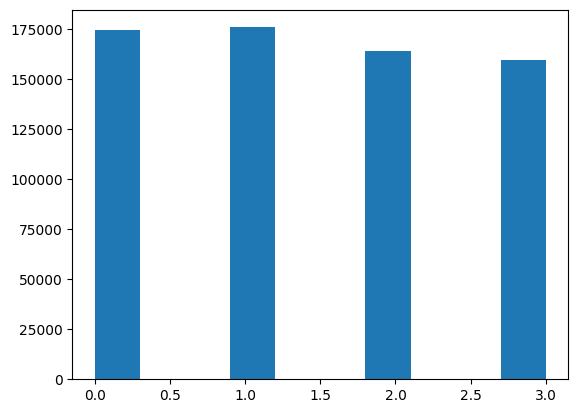

In [13]:
plt.hist(muba_df["label"])

In [14]:
# Check this works
boundary_points_df = find_boundary_points(muba_df, X_test_A, MUBA_ITERS, classes = 4)

In [15]:
boundary_points_df.head(-5)

,alpha_class_0,alpha_class_1,alpha_class_2,alpha_class_3,class_0_index,class_1_index,class_2_index,class_3_index,image,type,label
0,0.498940,0.501060,0.000000,0.000000,1.0,0.0,NaN,NaN,"[[[142.76250729433636], [139.25508564728437], ...",boundary,1
1,0.204854,0.795146,0.000000,0.000000,1.0,2.0,NaN,NaN,"[[[89.60956475903139], [85.63383314266196], [8...",boundary,1
2,0.348414,0.000000,0.651586,0.000000,1.0,NaN,4.0,NaN,"[[[122.07636939728087], [122.727955821804], [1...",boundary,2
3,0.402961,0.597039,0.000000,0.000000,1.0,5.0,NaN,NaN,"[[[255.0], [255.0], [255.0], [254.0], [253.597...",boundary,1
4,0.347764,0.000000,0.000000,0.652236,1.0,NaN,NaN,6.0,"[[[103.6811917061824], [103.02895546353665], [...",boundary,3
...,...,...,...,...,...,...,...,...,...,...,...
48714,0.000000,0.000000,0.242681,0.757319,NaN,NaN,281.0,286.0,"[[[22.514637498547206], [22.7573187492736], [2...",boundary,3
48715,0.000000,0.000000,0.209121,0.790879,NaN,NaN,281.0,292.0,"[[[35.23581525161464], [36.235815251614646], [...",boundary,3
48716,0.000000,0.000000,0.291069,0.708931,NaN,NaN,281.0,292.0,"[[[33.76076331112213], [34.76076331112213], [3...",boundary,3
48717,0.000000,0.000000,0.206351,0.793649,NaN,NaN,281.0,293.0,"[[[32.9047278615754], [31.523782289260325], [2...",boundary,3


In [16]:
predictions_boundary = model.predict(np.stack(boundary_points_df["image"]))
activations_boundary = activations_model.predict(np.stack(boundary_points_df["image"]))

1523/1523 [==============================] - 12s 8ms/step


In [17]:
test_set_A_df = pd.DataFrame({
    "alpha_class_0" : [label[0] for label in y_test_A],
    "alpha_class_1" : [label[1] for label in y_test_A],
    "alpha_class_2" : [label[2] for label in y_test_A],
    "alpha_class_3" : [label[3] for label in y_test_A],
    "class_0_index" : None,
    "class_1_index" : None,
    "class_2_index" : None,
    "class_3_index" : None,
    "image" : [image for image in X_test_A],
    "type" : "A",
    "label" : [np.argmax(l) for l in y_test_A],
    "predictions_0" : [p[0] for p in predictions_A],
    "predictions_1" : [p[1] for p in predictions_A],
    "predictions_2" : [p[2] for p in predictions_A],
    "predictions_3" : [p[3] for p in predictions_A],
    "argmax_pred" : [np.argmax(p) for p in predictions_A],
    "activations" : [a for a in activations_A]
})
test_set_B_df = pd.DataFrame({
    "alpha_class_0" : [label[0] for label in y_test_B],
    "alpha_class_1" : [label[1] for label in y_test_B],
    "alpha_class_2" : [label[2] for label in y_test_B],
    "alpha_class_3" : [label[3] for label in y_test_B],
    "class_0_index" : None,
    "class_1_index" : None,
    "class_2_index" : None,
    "class_3_index" : None,
    "image" : [image for image in X_test_B],
    "type" : "B",
    "label" : [np.argmax(l) for l in y_test_B],
    "predictions_0" : [p[0] for p in predictions_B],
    "predictions_1" : [p[1] for p in predictions_B],
    "predictions_2" : [p[2] for p in predictions_B],
    "predictions_3" : [p[3] for p in predictions_B],
    "argmax_pred" : [np.argmax(p) for p in predictions_B],
    "activations" : [a for a in activations_B]
})

boundary_points_df["predictions_0"] = [p[0] for p in predictions_boundary]
boundary_points_df["predictions_1"] = [p[1] for p in predictions_boundary]
boundary_points_df["predictions_2"] = [p[0] for p in predictions_boundary]
boundary_points_df["predictions_3"] = [p[1] for p in predictions_boundary]
boundary_points_df["argmax_pred"] = [np.argmax(p) for p in predictions_boundary]
boundary_points_df["activations"] = [a for a in activations_boundary]

In [18]:
df = pd.concat([test_set_A_df, test_set_B_df, muba_df, boundary_points_df],axis=0, ignore_index=True)

In [19]:
muba_projections = TSNE(2,random_state=1, verbose = 2).fit_transform(np.stack(df["activations"]))

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 723864 samples in 0.046s...
[t-SNE] Computed neighbors for 723864 samples in 1971.909s...
[t-SNE] Computed conditional probabilities for sample 1000 / 723864
[t-SNE] Computed conditional probabilities for sample 2000 / 723864
[t-SNE] Computed conditional probabilities for sample 3000 / 723864
[t-SNE] Computed conditional probabilities for sample 4000 / 723864
[t-SNE] Computed conditional probabilities for sample 5000 / 723864
[t-SNE] Computed conditional probabilities for sample 6000 / 723864
[t-SNE] Computed conditional probabilities for sample 7000 / 723864
[t-SNE] Computed conditional probabilities for sample 8000 / 723864
[t-SNE] Computed conditional probabilities for sample 9000 / 723864
[t-SNE] Computed conditional probabilities for sample 10000 / 723864
[t-SNE] Computed conditional probabilities for sample 11000 / 723864
[t-SNE] Computed conditional probabilities for sample 12000 / 723864
[t-SNE] Computed conditional prob

In [20]:
df["projection_x"] = [x[0] for x in muba_projections]
df["projection_y"] = [x[1] for x in muba_projections]

In [21]:
df_to_save = df.drop(columns=["image"])
df_to_save.to_pickle("muba_df.csv")

In [2]:
df = pd.read_pickle("muba_df.csv")

In [3]:
true_images_A_df = df[df["type"] == "A"]
true_images_B_df = df[df["type"] == "B"]

mixup_images_df =  df[df["type"] == "mix"]
boundary_images_df = df[df["type"] == "boundary"]

true_A_class_0 = true_images_A_df[true_images_A_df["label"] == 0]
true_A_class_1 = true_images_A_df[true_images_A_df["label"] == 1]
true_A_class_2 = true_images_A_df[true_images_A_df["label"] == 2]
true_A_class_3 = true_images_A_df[true_images_A_df["label"] == 3]

true_B_class_0 = true_images_B_df[true_images_B_df["label"] == 0]
true_B_class_1 = true_images_B_df[true_images_B_df["label"] == 1]
true_B_class_2 = true_images_B_df[true_images_B_df["label"] == 2]
true_B_class_3 = true_images_B_df[true_images_B_df["label"] == 3]

mixup_0 = mixup_images_df[mixup_images_df["label"] == 0]
mixup_1 = mixup_images_df[mixup_images_df["label"] == 1]
mixup_2 = mixup_images_df[mixup_images_df["label"] == 2]
mixup_3 = mixup_images_df[mixup_images_df["label"] == 3]

true_A_errors = true_images_A_df[true_images_A_df["label"] != true_images_A_df["argmax_pred"]]
true_B_errors = true_images_B_df[true_images_B_df["label"] != true_images_B_df["argmax_pred"]]
mixup_errors = mixup_images_df[mixup_images_df["label"] != mixup_images_df["argmax_pred"]]

error_free_true_A_class_0 = true_A_class_0[true_A_class_0["label"] == true_A_class_0["argmax_pred"]]
error_free_true_A_class_1 = true_A_class_1[true_A_class_1["label"] == true_A_class_1["argmax_pred"]]
error_free_true_A_class_2 = true_A_class_2[true_A_class_2["label"] == true_A_class_2["argmax_pred"]]
error_free_true_A_class_3 = true_A_class_3[true_A_class_3["label"] == true_A_class_3["argmax_pred"]]

error_free_mixup_class_0 = mixup_0[mixup_0["label"] == mixup_0["argmax_pred"]]
error_free_mixup_class_1 = mixup_1[mixup_1["label"] == mixup_1["argmax_pred"]]
error_free_mixup_class_2 = mixup_2[mixup_2["label"] == mixup_2["argmax_pred"]]
error_free_mixup_class_3 = mixup_3[mixup_3["label"] == mixup_3["argmax_pred"]]

In [4]:
mixup_errors_0_1 = mixup_errors[(mixup_errors["alpha_class_0"] > 0) & (mixup_errors["alpha_class_1"] > 0)]
mixup_errors_0_2 = mixup_errors[(mixup_errors["alpha_class_0"] > 0) & (mixup_errors["alpha_class_2"] > 0)]
mixup_errors_0_3 = mixup_errors[(mixup_errors["alpha_class_0"] > 0) & (mixup_errors["alpha_class_3"] > 0)]
mixup_errors_1_2 = mixup_errors[(mixup_errors["alpha_class_1"] > 0) & (mixup_errors["alpha_class_2"] > 0)]
mixup_errors_1_3 = mixup_errors[(mixup_errors["alpha_class_1"] > 0) & (mixup_errors["alpha_class_3"] > 0)]
mixup_errors_2_3 = mixup_errors[(mixup_errors["alpha_class_2"] > 0) & (mixup_errors["alpha_class_3"] > 0)]

boundaries_0_1 = boundary_images_df[(boundary_images_df["alpha_class_0"] > 0) & (boundary_images_df["alpha_class_1"] > 0)]
boundaries_0_2 = boundary_images_df[(boundary_images_df["alpha_class_0"] > 0) & (boundary_images_df["alpha_class_2"] > 0)]
boundaries_0_3 = boundary_images_df[(boundary_images_df["alpha_class_0"] > 0) & (boundary_images_df["alpha_class_3"] > 0)]
boundaries_1_2 = boundary_images_df[(boundary_images_df["alpha_class_1"] > 0) & (boundary_images_df["alpha_class_2"] > 0)]
boundaries_1_3 = boundary_images_df[(boundary_images_df["alpha_class_1"] > 0) & (boundary_images_df["alpha_class_3"] > 0)]
boundaries_2_3 = boundary_images_df[(boundary_images_df["alpha_class_2"] > 0) & (boundary_images_df["alpha_class_3"] > 0)]

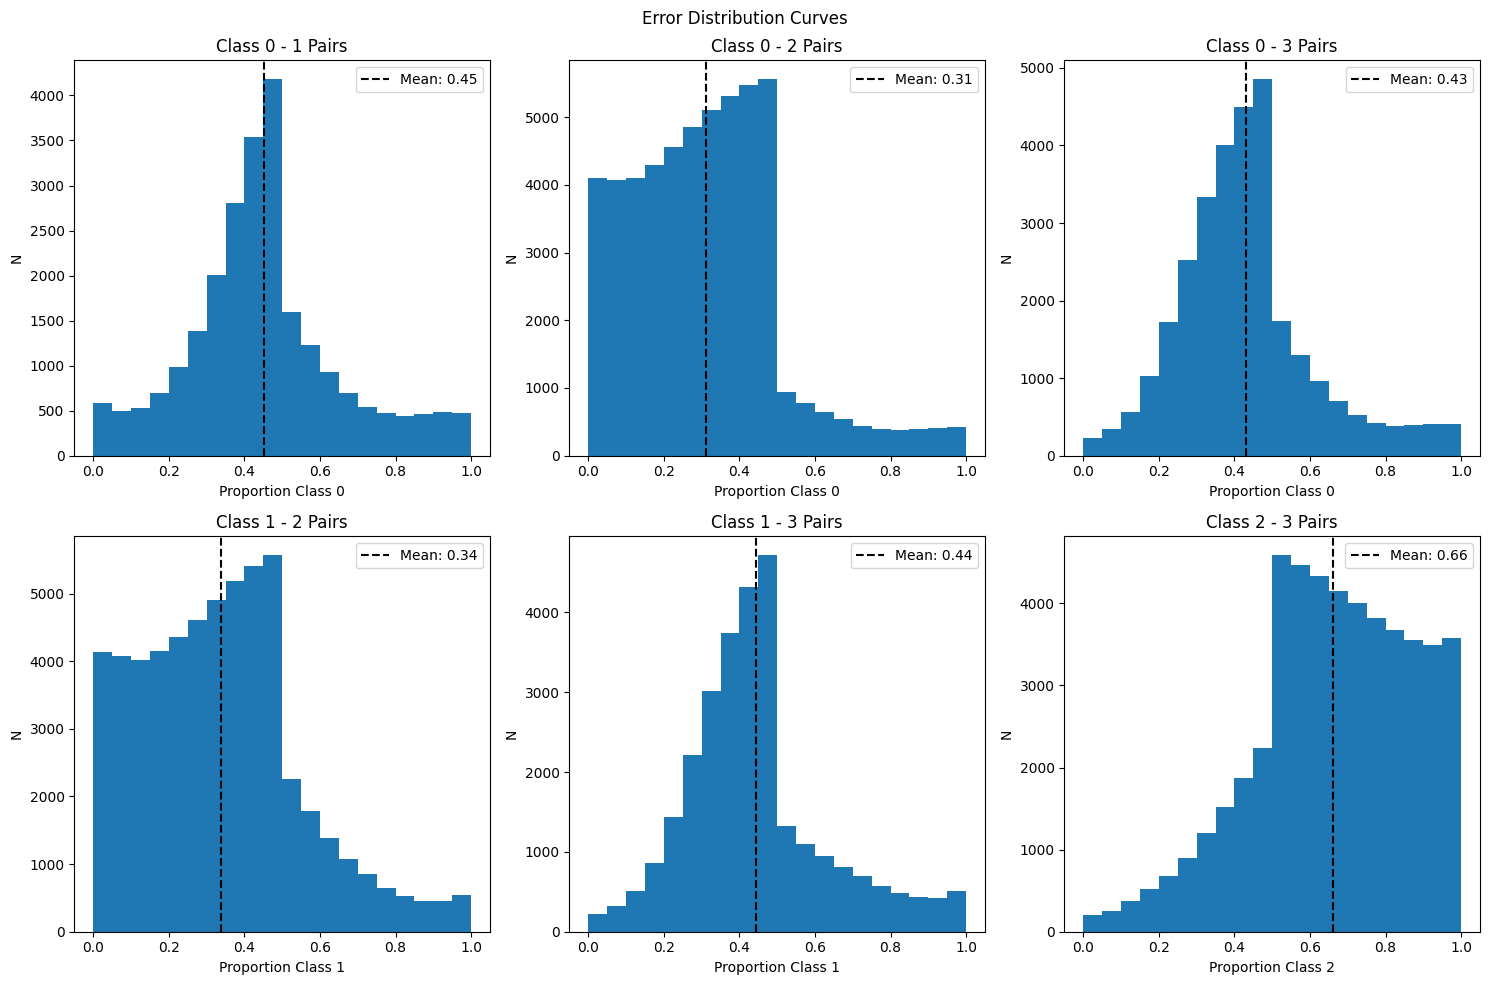

In [5]:
fig, axs = plt.subplots(2,3,figsize=(15,10))

#x_labels = ['Proportion Choroidal Neovascularization', 'Proportion Choroidal Neovascularization', 'Proportion Choroidal Neovascularization', 'Proportion Diabetic Macular Edema', 'Proportion Diabetic Macular Edema', 'Proportion Drusen']
x_labels=["Proportion Class 0", "Proportion Class 0", "Proportion Class 0", "Proportion Class 1", "Proportion Class 1", "Proportion Class 2"]
alpha_keys = ["alpha_class_0","alpha_class_0","alpha_class_0","alpha_class_1","alpha_class_1","alpha_class_2"]
titles = ["Class 0 - 1 Pairs","Class 0 - 2 Pairs","Class 0 - 3 Pairs","Class 1 - 2 Pairs","Class 1 - 3 Pairs","Class 2 - 3 Pairs",]
errors = [mixup_errors_0_1,mixup_errors_0_2,mixup_errors_0_3,mixup_errors_1_2,mixup_errors_1_3,mixup_errors_2_3]

for ax, x, e, key, t in zip(axs.flat, x_labels, errors, alpha_keys, titles):
    ax.hist(e[key], bins = [i/20 for i in range(21)])
    ax.set_xlabel(x)
    ax.set_ylabel("N")
    ax.set_title(t)
    ax.axvline(np.mean(e[key]),linestyle = "--", color = "black",label=f"Mean: {round(np.mean(e[key]),2)}")
    ax.legend()

plt.suptitle("Error Distribution Curves")
fig.tight_layout()

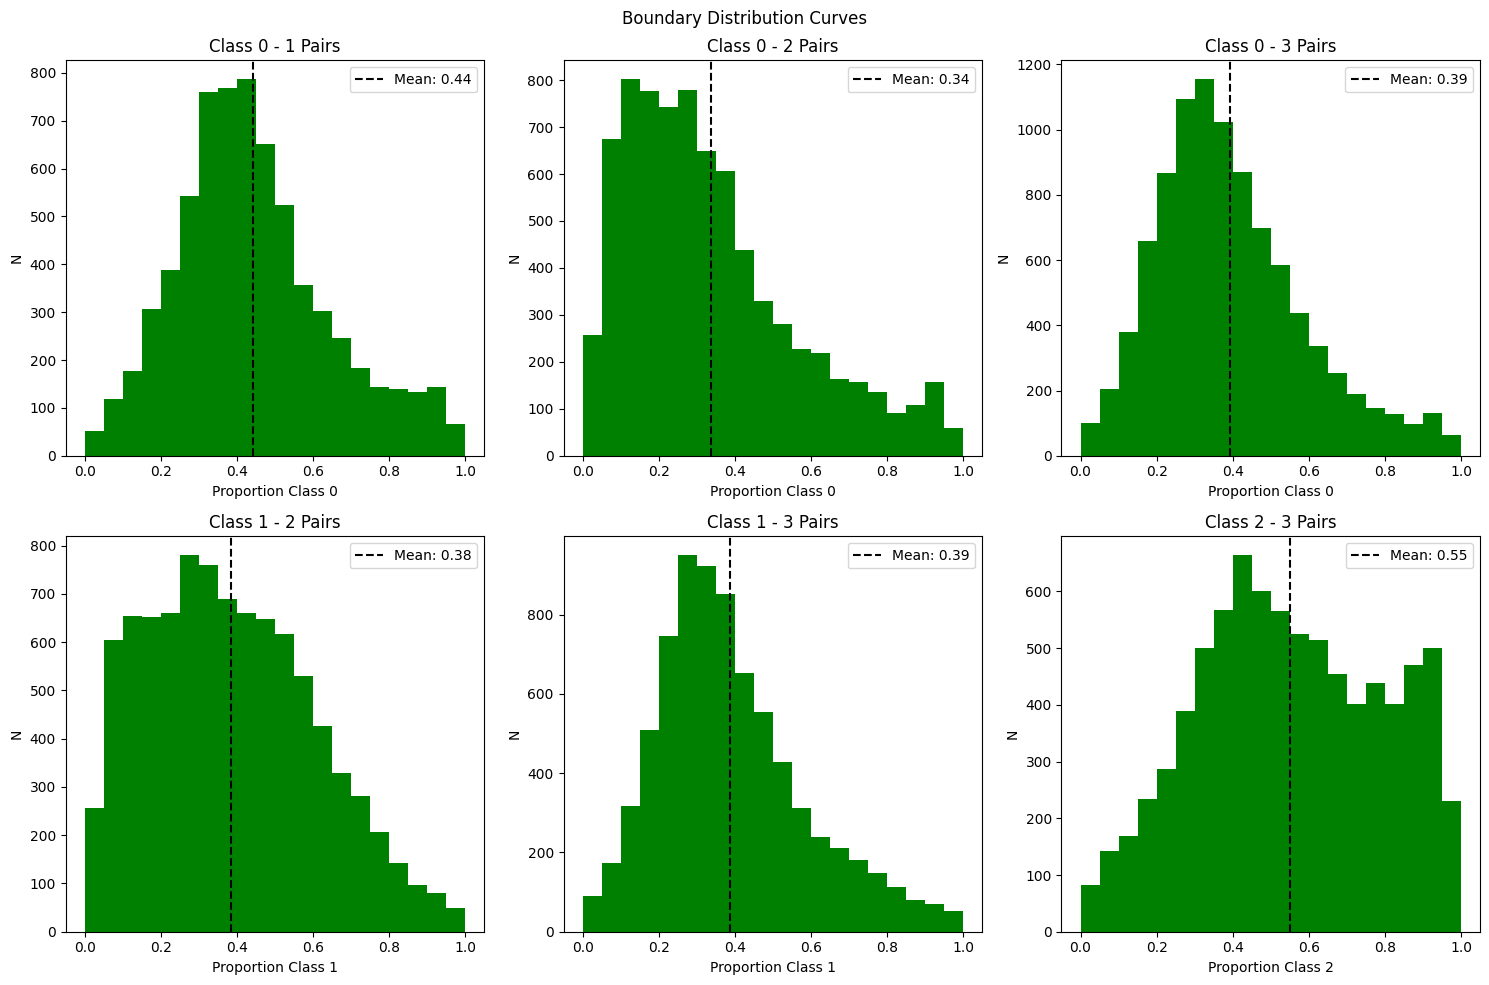

In [6]:
fig, axs = plt.subplots(2,3,figsize=(15,10))

#x_labels = ['Proportion Choroidal Neovascularization', 'Proportion Choroidal Neovascularization', 'Proportion Choroidal Neovascularization', 'Proportion Diabetic Macular Edema', 'Proportion Diabetic Macular Edema', 'Proportion Drusen']
x_labels=["Proportion Class 0", "Proportion Class 0", "Proportion Class 0", "Proportion Class 1", "Proportion Class 1", "Proportion Class 2"]
alpha_keys = ["alpha_class_0","alpha_class_0","alpha_class_0","alpha_class_1","alpha_class_1","alpha_class_2"]
titles = ["Class 0 - 1 Pairs","Class 0 - 2 Pairs","Class 0 - 3 Pairs","Class 1 - 2 Pairs","Class 1 - 3 Pairs","Class 2 - 3 Pairs",]
errors = [boundaries_0_1,boundaries_0_2,boundaries_0_3,boundaries_1_2,boundaries_1_3,boundaries_2_3]

for ax, x, e, key, t in zip(axs.flat, x_labels, errors, alpha_keys, titles):
    ax.hist(e[key], bins = [i/20 for i in range(21)], color="green")
    ax.set_xlabel(x)
    ax.set_ylabel("N")
    ax.set_title(t)
    ax.axvline(np.mean(e[key]),linestyle = "--", color = "black",label=f"Mean: {round(np.mean(e[key]),2)}")
    ax.legend()

plt.suptitle("Boundary Distribution Curves")
fig.tight_layout()

In [7]:
print(classification_report(mixup_images_df["label"],mixup_images_df["argmax_pred"]))

              precision    recall  f1-score   support

           0       0.59      0.89      0.71    174590
           1       0.64      0.80      0.71    176000
           2       0.82      0.19      0.30    164160
           3       0.69      0.66      0.67    159390

    accuracy                           0.64    674140
   macro avg       0.68      0.63      0.60    674140
weighted avg       0.68      0.64      0.60    674140



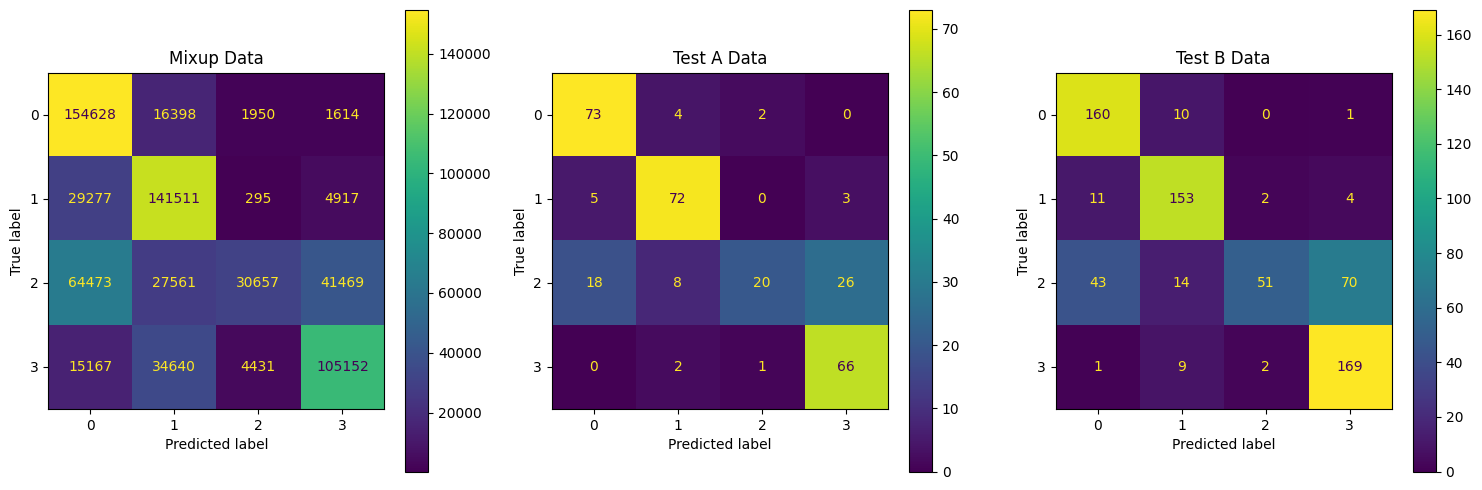

In [8]:
plot_3_confusion_matricies(mixup_images_df,true_images_A_df,true_images_B_df, labels = [0,1,2,3])

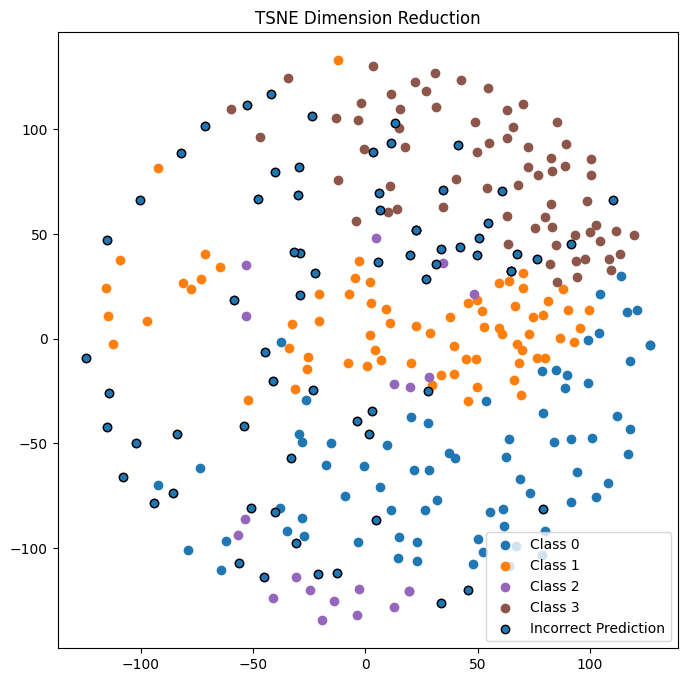

In [9]:
fig, ax = plt.subplots(figsize=(8, 8))

ax.scatter(true_A_class_0["projection_x"], true_A_class_0["projection_y"], color = "C0", label = "Class 0")
ax.scatter(true_A_class_1["projection_x"], true_A_class_1["projection_y"], color = "C1", label = "Class 1")
ax.scatter(true_A_class_2["projection_x"], true_A_class_2["projection_y"], color = "C4", label = "Class 2")
ax.scatter(true_A_class_3["projection_x"], true_A_class_3["projection_y"], color = "C5", label = "Class 3")

ax.scatter(true_A_errors["projection_x"], true_A_errors["projection_y"], color = None, edgecolors = "black", label = "Incorrect Prediction")

ax.set_title("TSNE Dimension Reduction")
ax.legend()

C:\Users\Will Poulett\AppData\Roaming\Python\Python311\site-packages\IPython\core\events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
C:\Users\Will Poulett\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


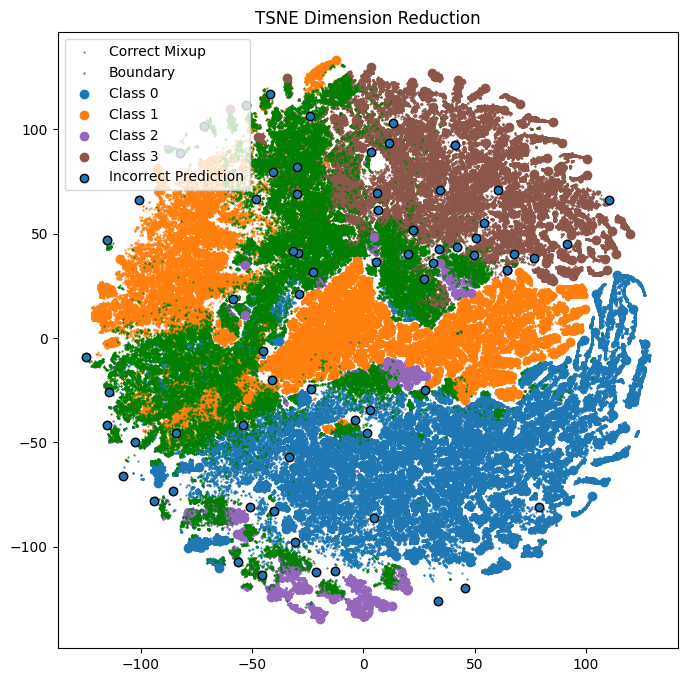

In [10]:
fig, ax = plt.subplots(figsize=(8, 8))

ax.scatter(error_free_mixup_class_0["projection_x"],error_free_mixup_class_0["projection_y"], color = "C0", marker = ".", s = 1, label = "Correct Mixup")
ax.scatter(error_free_mixup_class_1["projection_x"],error_free_mixup_class_1["projection_y"], color = "C1", marker = ".", s = 1)
ax.scatter(error_free_mixup_class_2["projection_x"],error_free_mixup_class_2["projection_y"], color = "C4", marker = ".", s = 1)
ax.scatter(error_free_mixup_class_3["projection_x"],error_free_mixup_class_3["projection_y"], color = "C5", marker = ".", s = 1)
ax.scatter(boundary_images_df["projection_x"],boundary_images_df["projection_y"], color = "green", marker = ".", s = 1, label = "Boundary")

ax.scatter(true_A_class_0["projection_x"], true_A_class_0["projection_y"], color = "C0", label = "Class 0")
ax.scatter(true_A_class_1["projection_x"], true_A_class_1["projection_y"], color = "C1", label = "Class 1")
ax.scatter(true_A_class_2["projection_x"], true_A_class_2["projection_y"], color = "C4", label = "Class 2")
ax.scatter(true_A_class_3["projection_x"], true_A_class_3["projection_y"], color = "C5", label = "Class 3")

ax.scatter(true_A_errors["projection_x"], true_A_errors["projection_y"], color = None, edgecolors = "black", label = "Incorrect Prediction")

ax.set_title("TSNE Dimension Reduction")
ax.legend()

In [11]:
multiple_boundaries_mask = boundary_images_df.duplicated(subset=["class_0_index","class_1_index"], keep=False)
multiple_boundaries = boundary_images_df[multiple_boundaries_mask]

In [12]:
multiple_boundaries

,alpha_class_0,alpha_class_1,alpha_class_2,alpha_class_3,class_0_index,class_1_index,class_2_index,class_3_index,type,label,predictions_0,predictions_1,predictions_2,predictions_3,argmax_pred,activations,projection_x,projection_y
675142,0.348414,0.0,0.651586,0.000000,1.0,NaN,4.0,NaN,boundary,2,0.400521,0.062760,0.400521,0.062760,0,"[0.15341751, 0.0, 0.0, 0.0, 0.17639452, 0.0, 0...",19.647509,26.777809
675144,0.347764,0.0,0.000000,0.652236,1.0,NaN,NaN,6.0,boundary,3,0.245601,0.088980,0.245601,0.088980,3,"[0.13323815, 0.008753821, 0.0, 0.0, 0.0, 0.0, ...",24.185675,19.436382
675146,0.363824,0.0,0.636176,0.000000,1.0,NaN,8.0,NaN,boundary,2,0.474730,0.007944,0.474730,0.007944,2,"[0.0, 0.0, 0.0, 0.0, 0.5468395, 0.0, 0.0, 0.0,...",-44.734406,-116.212631
675148,0.358920,0.0,0.000000,0.641080,1.0,NaN,NaN,10.0,boundary,3,0.357791,0.122275,0.357791,0.122275,3,"[0.06716786, 0.0, 0.002424959, 0.0, 0.04467971...",16.577747,24.408676
675149,0.149679,0.0,0.850321,0.000000,1.0,NaN,11.0,NaN,boundary,2,0.389300,0.032509,0.389300,0.032509,2,"[0.0, 0.0, 0.0, 0.0, 0.33411235, 0.0, 0.0, 0.0...",13.913039,-19.720263
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
723859,0.000000,0.0,0.159364,0.840636,NaN,NaN,281.0,296.0,boundary,3,0.023177,0.441228,0.023177,0.441228,3,"[0.016019851, 0.066570476, 0.0, 0.0, 0.0, 0.0,...",-38.464211,93.617836
723860,0.000000,0.0,0.397260,0.602740,NaN,NaN,281.0,296.0,boundary,3,0.291764,0.336521,0.291764,0.336521,1,"[0.074108586, 0.0, 0.0, 0.0, 0.0, 0.0, 0.05048...",-22.658028,48.826286
723861,0.000000,0.0,0.558670,0.441330,NaN,NaN,281.0,297.0,boundary,2,0.358696,0.377515,0.358696,0.377515,1,"[0.0, 0.0, 0.0, 0.0, 0.039874434, 0.0, 0.0, 0....",-99.540031,-2.818113
723862,0.000000,0.0,0.450918,0.549082,NaN,NaN,281.0,299.0,boundary,3,0.081451,0.049119,0.081451,0.049119,3,"[0.056205675, 0.16080572, 0.0, 0.0, 0.01822191...",44.502907,30.775919


In [13]:
POINT_0 = 1
POINT_1 = 278

POINT_0_df = true_A_class_0.loc[[POINT_0]]
POINT_1_df = true_A_class_1.loc[[POINT_1]]

point_1_df = mixup_images_df[mixup_images_df["class_0_index"]==POINT_0]
path_df = point_1_df[point_1_df["class_1_index"]==POINT_1]

boundary_points_1 = boundary_images_df[boundary_images_df["class_0_index"]==POINT_0]
boundary_point = boundary_points_1[boundary_points_1["class_1_index"]==POINT_1]

if len(POINT_0_df) == 0:
    print(f"Point {POINT_0} is not in this class")
if len(POINT_1_df) == 0:
    print(f"Point {POINT_1} is not in this class")

path_df = pd.concat([POINT_0_df, POINT_1_df, boundary_point, path_df],axis=0,ignore_index=False).sort_values("alpha_class_0")


C:\Users\Will Poulett\AppData\Roaming\Python\Python311\site-packages\IPython\core\events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
C:\Users\Will Poulett\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


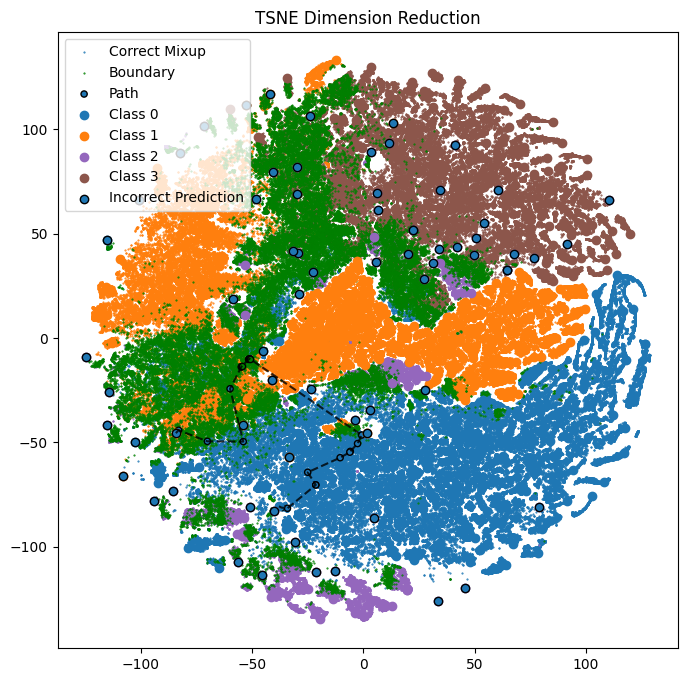

In [14]:
fig, ax = plt.subplots(figsize=(8, 8))

ax.scatter(error_free_mixup_class_0["projection_x"],error_free_mixup_class_0["projection_y"], color = "C0", marker = ".", s = 1, label = "Correct Mixup")
ax.scatter(error_free_mixup_class_1["projection_x"],error_free_mixup_class_1["projection_y"], color = "C1", marker = ".", s = 1)
ax.scatter(error_free_mixup_class_2["projection_x"],error_free_mixup_class_2["projection_y"], color = "C4", marker = ".", s = 1)
ax.scatter(error_free_mixup_class_3["projection_x"],error_free_mixup_class_3["projection_y"], color = "C5", marker = ".", s = 1)
ax.scatter(boundary_images_df["projection_x"],boundary_images_df["projection_y"], color = "green", marker = ".", s = 1, label = "Boundary")
ax.plot(path_df["projection_x"],path_df["projection_y"],alpha=0.8,linestyle="--",color="black")

ax.scatter(path_df["projection_x"],path_df["projection_y"],marker="o",s=20,c=["C0" if l == 0 else "C1" for l in path_df["argmax_pred"]], edgecolors = "black",label="Path")
ax.scatter(boundary_point["projection_x"],boundary_point["projection_y"],marker="o",s=20,c="green", edgecolors = "black")

ax.scatter(true_A_class_0["projection_x"], true_A_class_0["projection_y"], color = "C0", label = "Class 0")
ax.scatter(true_A_class_1["projection_x"], true_A_class_1["projection_y"], color = "C1", label = "Class 1")
ax.scatter(true_A_class_2["projection_x"], true_A_class_2["projection_y"], color = "C4", label = "Class 2")
ax.scatter(true_A_class_3["projection_x"], true_A_class_3["projection_y"], color = "C5", label = "Class 3")

ax.scatter(true_A_errors["projection_x"], true_A_errors["projection_y"], color = None, edgecolors = "black", label = "Incorrect Prediction")

ax.set_title("TSNE Dimension Reduction")
ax.legend()

In [17]:
from scipy import spatial
from collections import Counter

# This may be a function that we want to change for different models, so we define it within the notebook.
def get_distances():

    all_images_without_B_df = df[df["type"] != "B"].reset_index()
    activations_A = [a for a in true_images_A_df["activations"]]
    activations_B = [a for a in true_images_B_df["activations"]]
    activations_mixup = [a for a in mixup_images_df["activations"]]
    activations_boundary = [a for a in boundary_images_df["activations"]]
    all = [a for a in all_images_without_B_df["activations"]]

    tree_true_A = spatial.KDTree(activations_A)
    tree_true_B = spatial.KDTree(activations_B)
    tree_mixup  = spatial.KDTree(activations_mixup)
    tree_boundaries = spatial.KDTree(activations_boundary)
    tree_all = spatial.KDTree(all)

    distances_to_all = []
    distances_B_to_boundary = []
    distances_B_to_mixup = []
    B_class_0_to_boundary = []
    B_class_1_to_boundary = []
    B_class_2_to_boundary = []
    B_class_3_to_boundary = []
    B_class_0_incorrect_to_boundary = []
    B_class_1_incorrect_to_boundary = []
    B_class_2_incorrect_to_boundary = []
    B_class_3_incorrect_to_boundary = []
    B_class_0_correct_to_boundary = []
    B_class_1_correct_to_boundary = []
    B_class_2_correct_to_boundary = []
    B_class_3_correct_to_boundary = []
    types = []
    distance_B_to_B = []
    
    distances_A_to_boundary = []
    A_class_0_to_boundary = []
    A_class_1_to_boundary = []
    A_class_2_to_boundary = []
    A_class_3_to_boundary = []
    A_class_0_incorrect_to_boundary = []
    A_class_1_incorrect_to_boundary = []
    A_class_2_incorrect_to_boundary = []
    A_class_3_incorrect_to_boundary = []
    distance_A_to_A = []

    for vector, label, pred in zip(activations_B,true_images_B_df["label"],true_images_B_df["argmax_pred"]):

        distance, id = tree_all.query(vector)
        types.append(all_images_without_B_df.loc[[id]]["type"][id])
        distances_to_all.append(distance)

        boundary_dist = tree_boundaries.query(vector)[0]

        distance_B_to_B.append(tree_true_B.query(vector,2)[0][1])
        distances_B_to_boundary.append(boundary_dist)
        distances_B_to_mixup.append(tree_mixup.query(vector)[0])

        if label == 0:
            B_class_0_to_boundary.append(boundary_dist)
            if pred != label:#Incorrect
                B_class_0_incorrect_to_boundary.append(boundary_dist)
            else:
                B_class_0_correct_to_boundary.append(boundary_dist)
        elif label == 1:
            B_class_1_to_boundary.append(boundary_dist)
            if pred != label:#Incorrect
                B_class_1_incorrect_to_boundary.append(boundary_dist)
            else:
                B_class_1_correct_to_boundary.append(boundary_dist)
        elif label == 2:
            B_class_2_to_boundary.append(boundary_dist)
            if pred != label:#Incorrect
                B_class_2_incorrect_to_boundary.append(boundary_dist)
            else:
                B_class_2_correct_to_boundary.append(boundary_dist)
        elif label == 3:
            B_class_3_to_boundary.append(boundary_dist)
            if pred != label:#Incorrect
                B_class_3_incorrect_to_boundary.append(boundary_dist)
            else:
                B_class_3_correct_to_boundary.append(boundary_dist)

    for vector, label, pred in zip(activations_A, true_images_A_df["label"],true_images_A_df["argmax_pred"]):

        boundary_dist = tree_boundaries.query(vector)[0]

        distance_A_to_A.append(tree_true_A.query(vector,2)[0][1])
        distances_A_to_boundary.append(boundary_dist)

        if label == 0:
            A_class_0_to_boundary.append(boundary_dist)
            if pred != label: #Incorrect
                A_class_0_incorrect_to_boundary.append(boundary_dist)
        elif label == 1:
            A_class_1_to_boundary.append(boundary_dist)
            if pred != label:#Incorrect
                A_class_1_incorrect_to_boundary.append(boundary_dist)
        elif label == 2:
            A_class_2_to_boundary.append(boundary_dist)
            if pred != label:#Incorrect
                A_class_2_incorrect_to_boundary.append(boundary_dist)
        elif label == 3:
            A_class_3_to_boundary.append(boundary_dist)
            if pred != label:#Incorrect
                A_class_3_incorrect_to_boundary.append(boundary_dist)


    counts = Counter(types)

    print("Average Distance between Set B Images and all other images: ", np.mean(distances_to_all))
    print("Counts: ",counts)
    print("Average shortest distance from Set B Images to Boundary: ",np.mean(distances_B_to_boundary))
    print("Average shortest distance from Set B Images to Mixup Point: ",np.mean(distances_B_to_mixup))
    print("Average shortest distance from Set B Images to B Images: ",np.mean(distance_B_to_B))

    print("Average shortest distance from Test Set B Class 0 to Boundary: ",np.mean(B_class_0_to_boundary))
    print("Average shortest distance from Test Set B Class 1 to Boundary: ",np.mean(B_class_1_to_boundary))
    print("Average shortest distance from Test Set B Class 2 to Boundary: ",np.mean(B_class_2_to_boundary))
    print("Average shortest distance from Test Set B Class 3 to Boundary: ",np.mean(B_class_3_to_boundary))
    print("Average shortest distance from Test Set B Incorrect Class 0 to Boundary: ",np.mean(B_class_0_incorrect_to_boundary))
    print("Average shortest distance from Test Set B Incorrect Class 1 to Boundary: ",np.mean(B_class_1_incorrect_to_boundary))
    print("Average shortest distance from Test Set B Incorrect Class 2 to Boundary: ",np.mean(B_class_2_incorrect_to_boundary))
    print("Average shortest distance from Test Set B Incorrect Class 3 to Boundary: ",np.mean(B_class_3_incorrect_to_boundary))
   
    print("\nAverage shortest distance from Set A Images to Boundary: ",np.mean(distances_A_to_boundary))
    print("Average shortest distance from Set A Images to A Images: ",np.mean(distance_A_to_A))
    print("Average shortest distance from Test Set A Class 0 to Boundary: ",np.mean(A_class_0_to_boundary))
    print("Average shortest distance from Test Set A Class 1 to Boundary: ",np.mean(A_class_1_to_boundary))
    print("Average shortest distance from Test Set A Class 2 to Boundary: ",np.mean(A_class_2_to_boundary))
    print("Average shortest distance from Test Set A Class 3 to Boundary: ",np.mean(A_class_3_to_boundary))
    print("Average shortest distance from Test Set A Incorrect Class 0 to Boundary: ",np.mean(A_class_0_incorrect_to_boundary))
    print("Average shortest distance from Test Set A Incorrect Class 1 to Boundary: ",np.mean(A_class_1_incorrect_to_boundary))
    print("Average shortest distance from Test Set A Incorrect Class 2 to Boundary: ",np.mean(A_class_2_incorrect_to_boundary))
    print("Average shortest distance from Test Set A Incorrect Class 3 to Boundary: ",np.mean(A_class_3_incorrect_to_boundary))

    return distances_B_to_boundary, B_class_0_to_boundary, B_class_1_to_boundary, B_class_2_to_boundary, B_class_3_to_boundary, B_class_0_correct_to_boundary, B_class_1_correct_to_boundary, B_class_2_correct_to_boundary, B_class_3_correct_to_boundary
   

In [18]:
distances_B_to_boundary, B_class_0_to_boundary, B_class_1_to_boundary, B_class_2_to_boundary, B_class_3_to_boundary, B_class_0_correct_to_boundary, B_class_1_correct_to_boundary, B_class_2_correct_to_boundary, B_class_3_correct_to_boundary = get_distances()

Average Distance between Set B Images and all other images:  0.2869704020698543
Counts:  Counter({'mix': 659, 'boundary': 29, 'A': 12})
Average shortest distance from Set B Images to Boundary:  0.9096581689513511
Average shortest distance from Set B Images to Mixup Point:  0.2875843773492029
Average shortest distance from Set B Images to B Images:  0.5225747570959915
Average shortest distance from Test Set B Class 0 to Boundary:  1.3360575300352067
Average shortest distance from Test Set B Class 1 to Boundary:  0.7207155560326788
Average shortest distance from Test Set B Class 2 to Boundary:  0.5853376029678152
Average shortest distance from Test Set B Class 3 to Boundary:  1.0032217832933636
Average shortest distance from Test Set B Incorrect Class 0 to Boundary:  0.34174396870698165
Average shortest distance from Test Set B Incorrect Class 1 to Boundary:  0.3438470292852437
Average shortest distance from Test Set B Incorrect Class 2 to Boundary:  0.5367571126496857
Average shortest d

In [19]:
from scipy.stats import pearsonr

print(pearsonr(true_images_B_df[true_images_B_df["label"]==0]["predictions_0"],B_class_0_to_boundary)[0])
print(pearsonr(true_images_B_df[true_images_B_df["label"]==1]["predictions_1"],B_class_1_to_boundary)[0])
print(pearsonr(true_images_B_df[true_images_B_df["label"]==2]["predictions_2"],B_class_2_to_boundary)[0])
print(pearsonr(true_images_B_df[true_images_B_df["label"]==3]["predictions_3"],B_class_3_to_boundary)[0])
print("")
print(pearsonr(true_images_B_df[true_images_B_df["label"]==0][true_images_B_df["argmax_pred"]==0]["predictions_0"],B_class_0_correct_to_boundary)[0])
print(pearsonr(true_images_B_df[true_images_B_df["label"]==1][true_images_B_df["argmax_pred"]==1]["predictions_1"],B_class_1_correct_to_boundary)[0])
print(pearsonr(true_images_B_df[true_images_B_df["label"]==2][true_images_B_df["argmax_pred"]==2]["predictions_2"],B_class_2_correct_to_boundary)[0])
print(pearsonr(true_images_B_df[true_images_B_df["label"]==3][true_images_B_df["argmax_pred"]==3]["predictions_3"],B_class_3_correct_to_boundary)[0])

0.25996976261531346
0.5873799373933561
0.13525681669100517
0.710624528946279

0.3034313960365107
0.7191861349872808
0.46346811431552754
0.7786165072006849


C:\Users\Will Poulett\AppData\Local\Temp\ipykernel_21168\415269534.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(pearsonr(true_images_B_df[true_images_B_df["label"]==0][true_images_B_df["argmax_pred"]==0]["predictions_0"],B_class_0_correct_to_boundary)[0])
C:\Users\Will Poulett\AppData\Local\Temp\ipykernel_21168\415269534.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(pearsonr(true_images_B_df[true_images_B_df["label"]==1][true_images_B_df["argmax_pred"]==1]["predictions_1"],B_class_1_correct_to_boundary)[0])
C:\Users\Will Poulett\AppData\Local\Temp\ipykernel_21168\415269534.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(pearsonr(true_images_B_df[true_images_B_df["label"]==2][true_images_B_df["argmax_pred"]==2]["predictions_2"],B_class_2_correct_to_boundary)[0])
C:\Users\Will Poulett\AppData\Local\Temp\ipykernel_21168\415269534.py:11: UserWarning: Boolean S